# Lab 2 - Pitfalls of retrieval: When simple vector search fails!

In [2]:
# This cell is the same as Lab 1 till we create the collection collapsed into a single block

import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

from pypdf import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter

reader = PdfReader("microsoft_annual_report_2022.pdf")

pdf_texts = [p.extract_text().strip() for p in reader.pages]

pdf_texts = [text for text in pdf_texts if text]  # Filter the empty strings

character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""],
    chunk_size=1000,
    chunk_overlap=0
)
character_split_texts = character_splitter.split_text('\n\n'.join(pdf_texts))

token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=256)

token_split_texts = []
for text in character_split_texts:
    token_split_texts += token_splitter.split_text(text)
   

embedding_function = SentenceTransformerEmbeddingFunction()

chroma_client = chromadb.Client()

chroma_collection = chroma_client.create_collection("MicrosoftAnnualReport", embedding_function=embedding_function)

ids = [str(i) for i in range(len(token_split_texts))]

chroma_collection.add(ids=ids, documents=token_split_texts)

chroma_collection.count()

UniqueConstraintError: Collection MicrosoftAnnualReport already exists

In [3]:
import umap
import numpy as np
from tqdm import tqdm

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

/Users/damiangarayalde/Desktop/Work - Github Repos/AI/Advanced Retrieval for AI with Chroma/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [8]:
def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings   

In [9]:
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

100%|██████████| 349/349 [01:38<00:00,  3.53it/s]


(-3.060415196418762, 7.524823594093323, 1.0972334742546082, 8.713089048862457)

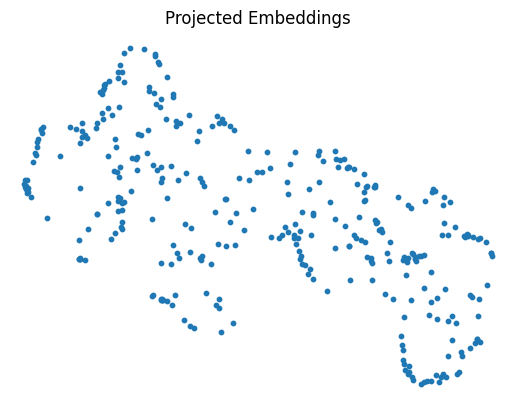

In [10]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.axis('off')

## Relevancy and Distraction

In [11]:
query = "What is the total revenue?"

query_embedding = embedding_function([query])[0]

results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents  = results['documents'][0]
retrieved_embeddings = results['embeddings'][0]

# for document in results['documents'][0]:
#     print(document)
#     print('')

In [12]:
projected_query_embedding      = project_embeddings([query_embedding],    umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:01<00:00,  4.01it/s]


(-3.060415196418762, 7.524823594093323, 1.0972334742546082, 8.713089048862457)

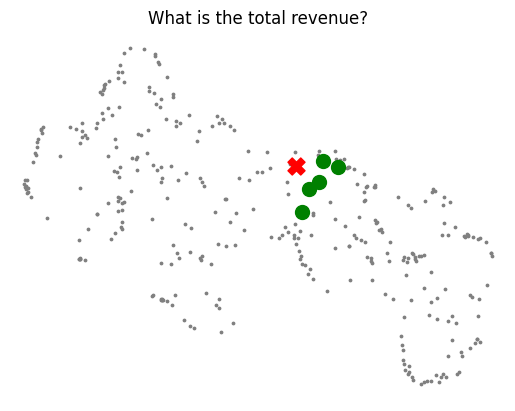

In [13]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[  :, 0], projected_dataset_embeddings[  :, 1], s=3, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='g', edgecolors='g')
plt.scatter(projected_query_embedding[     :, 0], projected_query_embedding[     :, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

In [14]:
query = "What is the strategy around artificial intelligence (AI) ?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

culture of trust can help navigate the challenges the world faces today. organizations of all sizes have digitized business - critical functions, redefining what they can expect from their business applications. customers are looking to unlock value while simplifying security and management. from infrastructure and data, to business applications and collaboration, we provide unique, differentiated value to customers. we are building a distributed computing fabric – across cloud and the edge – to help every organization build, run, and manage mission - critical workloads anywhere. in the next phase of innovation, artificial intelligence ( “ ai ” ) capabilities are rapidly advancing, fueled by data and knowledge of the world. we are enabling metaverse experiences at all layers of our stack, so customers can more effectively model, automate, simulate, and predict changes within their industrial

every organization turn its data into predictive and analytical power. with our new microsoft 

In [15]:
query_embedding      = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding      = project_embeddings([query_embedding],    umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)


100%|██████████| 5/5 [00:01<00:00,  3.39it/s]


(-3.060415196418762, 7.524823594093323, 1.0972334742546082, 8.713089048862457)

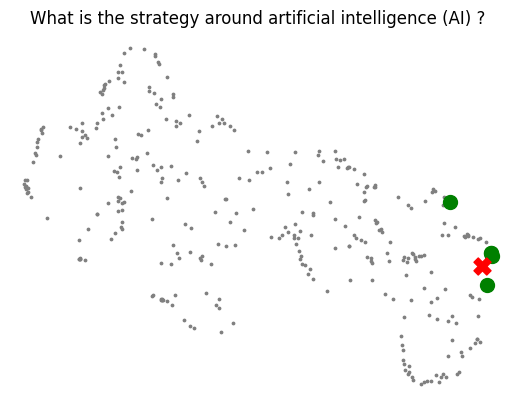

In [16]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[  :, 0], projected_dataset_embeddings[  :, 1], s=3, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='g', edgecolors='g')
plt.scatter(projected_query_embedding[     :, 0], projected_query_embedding[     :, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

In [17]:
query = "What has Michael Jordan done for us lately?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

we use metrics in assessing the performance of our business and to make informed decisions regarding the allocation of resources. we disclose metrics to enable investors to evaluate progress against our ambitions, provide transparency into performance trends, and reflect the continued evolution of our products and services. our commercial and other business metrics are fundamentally connected based on how customers use our products and

18 total rewards we develop dynamic, sustainable, market - driven, and strategic programs with the goal of providing a highly differentiated portfolio to attract, reward, and retain top talent and enable our employees to thrive. these programs reinforce our culture and values such as collaboration and growth mindset. managers evaluate and recommend rewards based on, for example, how well we leverage the work of others and contribute to the success of our colleagues. we monitor pay equity and career progress across multiple dimensions. as part of our eff

In [18]:
query_embedding      = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding      = project_embeddings([query_embedding],   umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)


100%|██████████| 5/5 [00:01<00:00,  3.62it/s]


(-3.060415196418762, 7.524823594093323, 1.0972334742546082, 8.713089048862457)

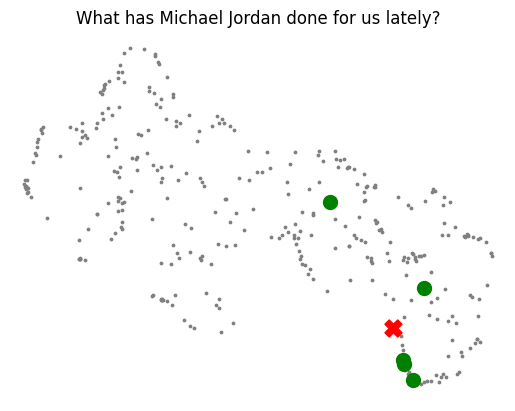

In [19]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[  :, 0], projected_dataset_embeddings[  :, 1], s=3, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='g', edgecolors='g')
plt.scatter(projected_query_embedding[     :, 0], projected_query_embedding[     :, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')